In [30]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
from torch.utils.data import Dataset, DataLoader
import random
import torchaudio
import sys
sys.path.append("..")
from utils.cnn import CNNNetwork
from utils.lstm import LSTMNetwork
from utils.numpyDataset import NumpyDataset
from utils.gpt4_architectures import *

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.MSELoss()
batch_size = 64

filex = '../dataset_generation/trainX.npy'
filey = '../dataset_generation/trainY.npy'
dataset = NumpyDataset(filex, filey)
inp_shape = dataset[0][0].shape
train_data, val_data = torch.utils.data.random_split(dataset, (55000, 5001))
train_dl = DataLoader(train_data, batch_size=batch_size)
val_dl = DataLoader(val_data, batch_size=batch_size)
print(inp_shape)
model1 = RecurrentAutoencoder(inp_shape[1], inp_shape[0], 1, 128)
model2 = LSTMAutoencoder(16, 128, 1)
model3 = LSTM_AE(seq_len=inp_shape[1], no_features=inp_shape[0], embedding_dim=128)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda
(16, 375)


In [47]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):
    i = 0
    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)
        input = torch.transpose(input, 1, 2)
        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, input)
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
#         if i%200 == 0:
#             print("batch", i, "loss", loss.item())
#         i+= 1
    
    metrics['t_loss'].append((sum(losses)/len(losses)))
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)
        input = torch.transpose(input, 1, 2)
        prediction = model(input)
        loss = loss_fn(prediction, input)
        losses.append(loss.item())
    
    metrics['v_loss'].append((sum(losses)/len(losses)))

In [48]:
print(model)
print('number of params:', sum(p.numel() for p in model1.parameters() if p.requires_grad))
print('number of params:', sum(p.numel() for p in model2.parameters() if p.requires_grad))
print('number of params:', sum(p.numel() for p in model3.parameters() if p.requires_grad))

raise
metrics = {
    't_loss': [],
    'v_loss': [],
}
print('****** STARTING TRAINING ******')
for epoch in range(100):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}")

print("Fininshed training")    



LSTM_AE(
  (encoder): Encoder(
    (LSTM1): LSTM(16, 64, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(64, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=16, bias=True)
  )
)
number of params: 1009680
number of params: 84096
number of params: 474128


RuntimeError: No active exception to reraise

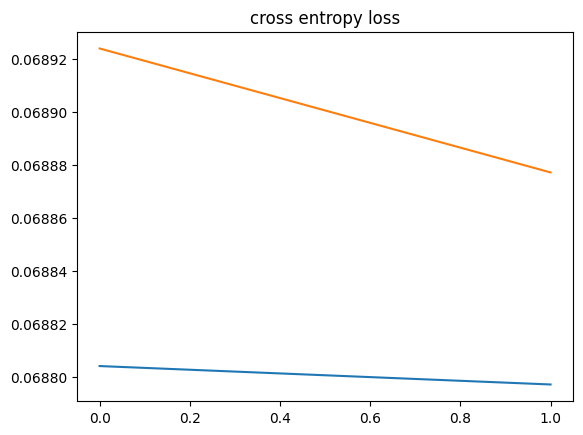

In [16]:
plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
#plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

torch.Size([1, 375, 16])


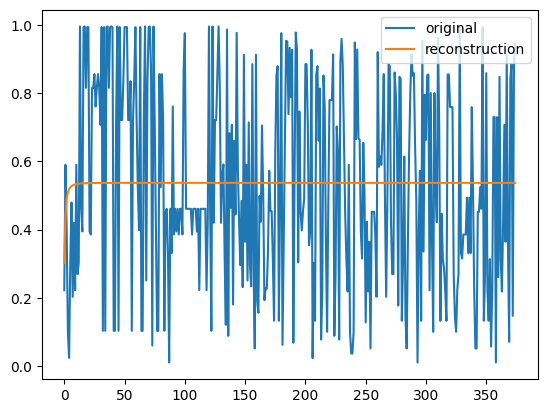

In [26]:
test = dataset[521][0]
test = torch.tensor(test.T)
model.cpu()
rc = model(test.unsqueeze(0))
print(rc.shape)
plt.plot(test[:, 0])
plt.plot(rc.squeeze().detach()[:, 0])
plt.legend(['original', 'reconstruction'])

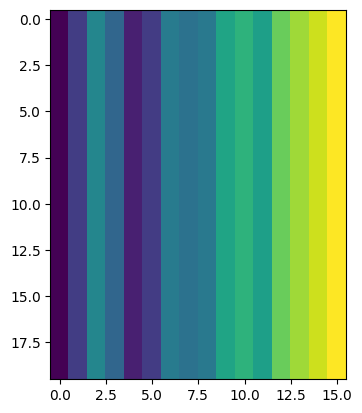

In [18]:
plt.imshow(rc.squeeze().detach()[100:120,:])